## Image classification with Convolutional Neural Networks

This is the minimal set of steps required to run an image classification task between two classes.

We will try to differentiate harbour seals & California sea lions.

In [128]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

Here we import the libraries we need. We'll learn about what each does during the course.

In [129]:
from fastai.imports import os, np, plt, PIL
from fastai.transforms import transforms_side_on, transforms_from_model
from fastai.conv_learner import ConvLearner, accuracy_np
from fastai.model import resnet34, torch
from fastai.dataset import ImageClassifierData

In [130]:
# Sanity checks for GPU - both should return true
print(torch.cuda.is_available())
print(torch.backends.cudnn.enabled)

True
True


In [168]:
PATH = '/home/paperspace/data/seal_or_sealion/'
sz = 224
data = ImageClassifierData.from_paths(PATH, transforms = transforms_from_model(resnet34, sz))
my_model = ConvLearner.pretrained(resnet34, data)
my_model.lr_find(start_lr = 1e-5)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   accuracy         
    0      0.807032   155.767853 0.585938  


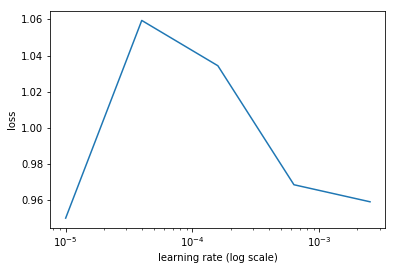

In [169]:
my_model.sched.plot(0)

In [183]:
learning_rate = 1e-3
# First train with precomputed activations
my_model = ConvLearner.pretrained(resnet34, data)
my_model.fit(learning_rate, 5)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   accuracy         
    0      0.819043   0.858122   0.477679  
    1      0.77193    0.514834   0.761161         
    2      0.715047   0.390665   0.856027         
    3      0.659225   0.32569    0.891741                 
    4      0.621213   0.278966   0.899554         
    5      0.576042   0.263373   0.907366         
    6      0.521546   0.252314   0.907366         



[0.25231448, 0.9073660671710968]

In [184]:
# Now train without precomputed activations & use image augmentation
# Since data was set up with image augmentation, we just need to set precompute = False

my_model_without_precompute = ConvLearner.pretrained(resnet34, data, precompute=False)
my_model_without_precompute.fit(learning_rate, 7)

HBox(children=(IntProgress(value=0, description='Epoch', max=8), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                 
    0      0.866329   0.606594   0.655134  
    1      0.740297   0.433847   0.811384                 
    2      0.66693    0.320862   0.876116                 
    3      0.61123    0.268296   0.891741                 
    4      0.568043   0.238449   0.909598                 
    5      0.524219   0.221025   0.917411                 
    6      0.484046   0.20837    0.925223                 
    7      0.458839   0.200673   0.925223                 



[0.20067292, 0.9252232015132904]

In [185]:
# Now unfreeze all layers & train with multiple cycles

my_model_without_precompute.unfreeze()
learning_rate_array=np.array([learning_rate/100, learning_rate/10, learning_rate])
my_model_without_precompute.fit(learning_rate_array, 5, cycle_len=1, cycle_mult = 2)

HBox(children=(IntProgress(value=0, description='Epoch', max=31), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                  
    0      0.400824   0.207199   0.925223  
    1      0.375307   0.209852   0.927455                  
    2      0.360713   0.214813   0.917411                  
    3      0.412154   0.199171   0.917411                  
    4      0.394136   0.185527   0.933036                  
    5      0.384405   0.189824   0.933036                  
    6      0.367177   0.185929   0.940848                  
    7      0.354905   0.171213   0.966518                  
    8      0.342595   0.161381   0.958705                  
    9      0.325153   0.156879   0.966518                  
    10     0.319967   0.154006   0.940848                 
    11     0.295052   0.149349   0.958705                  
    12     0.278308   0.147186   0.976562                  
    13     0.275304   0.142995   0.976562                  
    14     0.282339   0.146917   0.958705                  
    15     0.262924   0.149002   0.933036                

[0.12667707, 0.9408482015132904]

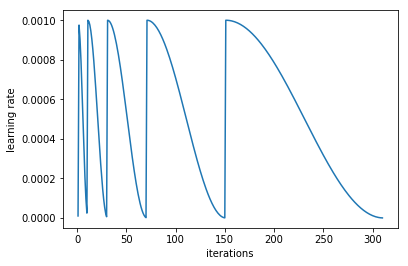

In [186]:
my_model_without_precompute.sched.plot_lr()

## View results

In [187]:
# Predict for validation set
log_preds,y = my_model_without_precompute.TTA()

In [188]:
print(log_preds[0].shape)
log_preds[0][:10]

(92, 2)


array([[-0.01597, -4.14486],
       [-0.08813, -2.47264],
       [-1.9951 , -0.14618],
       [-0.02935, -3.54303],
       [-0.17032, -1.85401],
       [-0.28833, -1.38437],
       [-0.01097, -4.51837],
       [-0.06286, -2.79814],
       [-0.03039, -3.50873],
       [-0.00437, -5.43446]], dtype=float32)

In [189]:
preds = np.argmax(log_preds[0], axis=1)  # from log probabilities to 0 or 1
#probs = np.exp(log_preds[:,1])        # pr(class1)
probs = np.mean(np.exp(log_preds), 0)
accuracy_np(probs, y)

0.9456521739130435

In [190]:
def rand_by_mask(mask): return np.random.choice(np.where(mask)[0], 4, replace=False)
def rand_by_correct(is_correct): return rand_by_mask((preds == data.val_y)==is_correct)

In [191]:
def plot_val_with_title(idxs, title):
    imgs = np.stack([data.val_ds[x][0] for x in idxs])
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(data.val_ds.denorm(imgs), rows=1, titles=title_probs)

In [192]:
def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])

In [193]:
def load_img_id(ds, idx): return np.array(PIL.Image.open(PATH+ds.fnames[idx]))

def plot_val_with_title(idxs, title):
    imgs = [load_img_id(data.val_ds,x) for x in idxs]
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(imgs, rows=1, titles=title_probs, figsize=(16,8))

Correctly classified


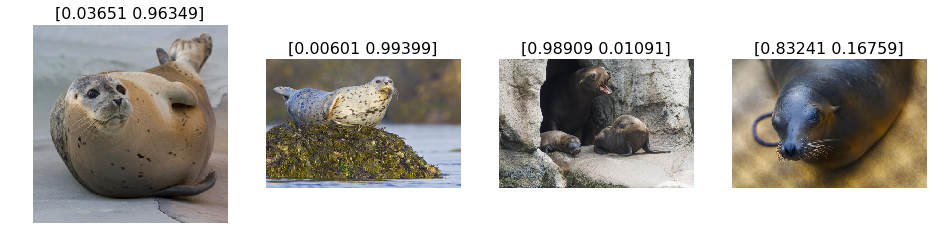

In [194]:
# 1. A few correct labels at random
plot_val_with_title(rand_by_correct(True), "Correctly classified")

Incorrectly classified


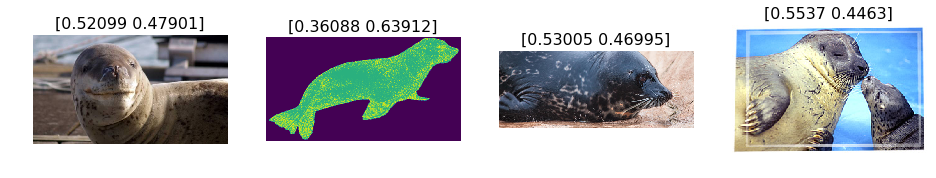

In [195]:
# 2. A few incorrect labels at random
plot_val_with_title(rand_by_correct(False), "Incorrectly classified")

In [196]:
def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[idxs])[:4]]

def most_by_correct(y, is_correct): 
    mult = -1 if (y==1)==is_correct else 1
    return most_by_mask(((preds == data.val_y)==is_correct) & (data.val_y == y), mult)

In [197]:
plot_val_with_title(most_by_correct(0, True), "Most correct cats")

TypeError: only integer scalar arrays can be converted to a scalar index

Most correct seals


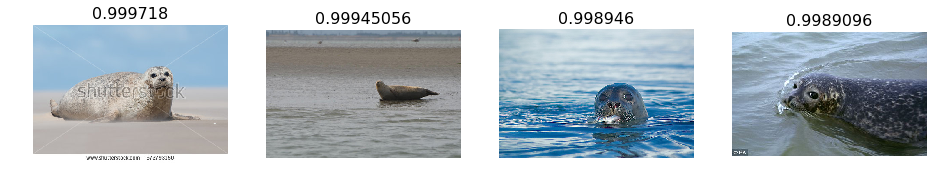

In [210]:
plot_val_with_title(most_by_correct(1, True), "Most correct seals")

Most incorrect cats


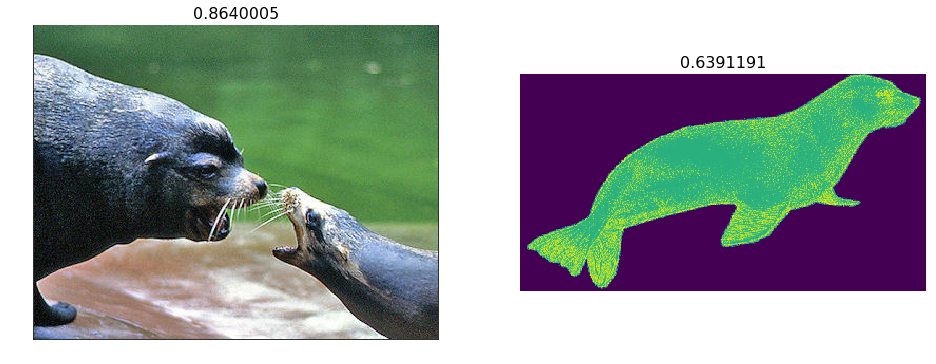

In [200]:
plot_val_with_title(most_by_correct(0, False), "Most incorrect cats")

Most incorrect dogs


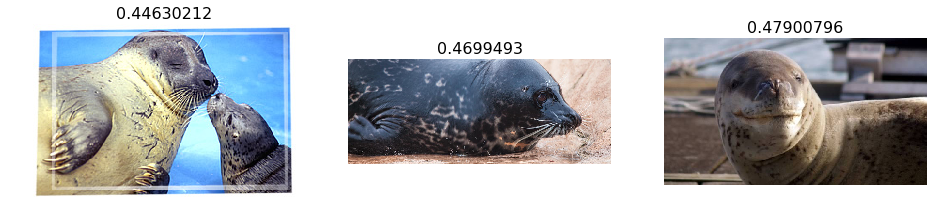

In [201]:
plot_val_with_title(most_by_correct(1, False), "Most incorrect dogs")

Most uncertain predictions


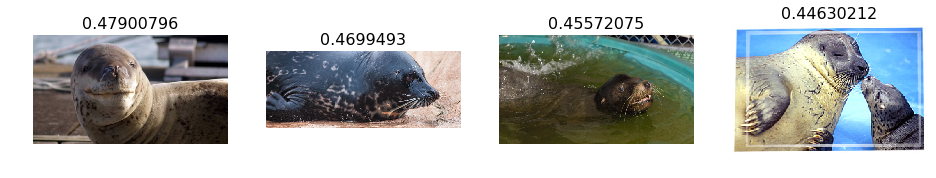

In [209]:
most_uncertain = np.argsort(np.abs(probs -0.5))[:4]
plot_val_with_title(most_uncertain, "Most uncertain predictions")

[[48  2]
 [ 3 39]]


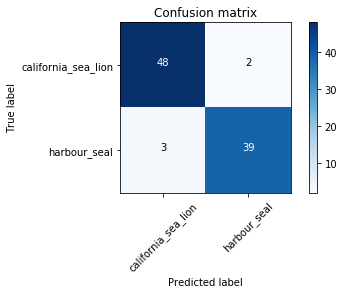

In [198]:
preds = np.argmax(probs, axis=1)
probs = probs[:,1]
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)
from fastai.plots import plot_confusion_matrix
plot_confusion_matrix(cm, data.classes)